In this task we are using **SARIMAX**, One of the methods available in Python to model and predict future points of a time series , which stands for **Seasonal AutoRegressive Integrated Moving Averages with eXogenous regressors**. Here, we will primarily focus on the **ARIMA** component, which is used to fit time-series data to better understand and **forecast future points** in the time series.

### Import the required packages

In [ ]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# Ignore the warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7

Let's load the data

In [ ]:
df = pd.read_csv('/content/Steel Price Trend.csv')
df.head()

,Unnamed: 0,Unnamed: 1
0,Date,Galvalum-1 mm
1,01-06-2020,55.30
2,02-06-2020,55.30
3,03-06-2020,55.30
4,04-06-2020,55.30


In [ ]:
# Set columns as Date & Galvalum-1 mm
df.columns = df.iloc[0]
# Drop row with index 0
df = df.drop(df.index[0])

In [ ]:
df.head()

,Date,Galvalum-1 mm
1,01-06-2020,55.30
2,02-06-2020,55.30
3,03-06-2020,55.30
4,04-06-2020,55.30
5,05-06-2020,55.30


Let's preprocess the data.

No missing values are present.

In [ ]:
df = df.rename(columns = {'Date ':'Date', ' Galvalum-1 mm ':'Galvalum'})
df.head()

,Date,Galvalum
1,01-06-2020,55.30
2,02-06-2020,55.30
3,03-06-2020,55.30
4,04-06-2020,55.30
5,05-06-2020,55.30


In [ ]:
# Check dtypes
df.dtypes

0
Date        object
Galvalum    object
dtype: object

**Type casting**

In [ ]:
#Convert object type to datetime for Date & object to float32 for Galvalum 
df['Date'] = pd.to_datetime(df['Date'])
# Convert object type to float32
df['Galvalum'] = df['Galvalum'].astype('float32')

In [ ]:
# Set Date as index 
df_ts = df.set_index('Date')
# Specify datetime frequency
df_ts = df_ts.asfreq('D')
df_ts.head()

,Galvalum
Date,
2020-01-06,55.299999
2020-01-07,53.500000
2020-01-08,56.000000
2020-01-09,61.000000
2020-01-10,65.000000


In [ ]:
# Fill the missing values
# The term bfill means that we use the value before filling in missing values
df_ts = df_ts.fillna(df_ts.bfill())

In [ ]:
# Check data shape
df_ts.shape

(588, 1)

### Time Series Forecasting with ARIMA

**Visualizing the time series**

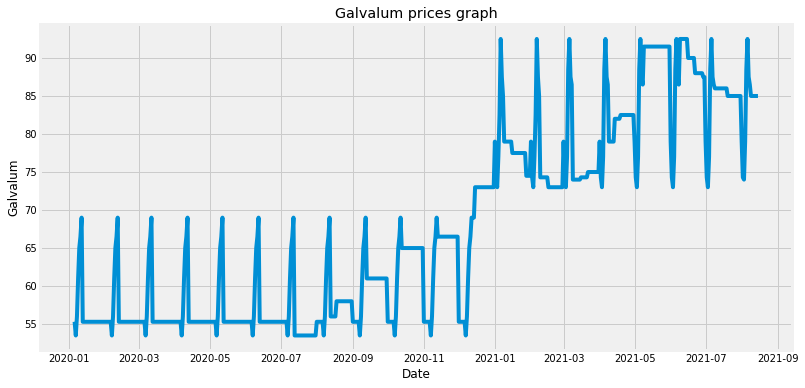

In [ ]:
plt.figure(figsize=(12,6))
plt.xlabel("Date")
plt.ylabel("Galvalum")
plt.title("Galvalum prices graph")
plt.plot(df_ts)

For time series forecasting, a series needs to be stationary. The series should have a constant mean, variance, and covariance.                 
Our time series is not stationary because the mean is not constant in the above graph.                                                                   
We need to have a stationary series to do time series forecasting. In the next stage, we will try to convert this into a stationary series.

In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.

Let us separate Trend and Seasonality from the time series.



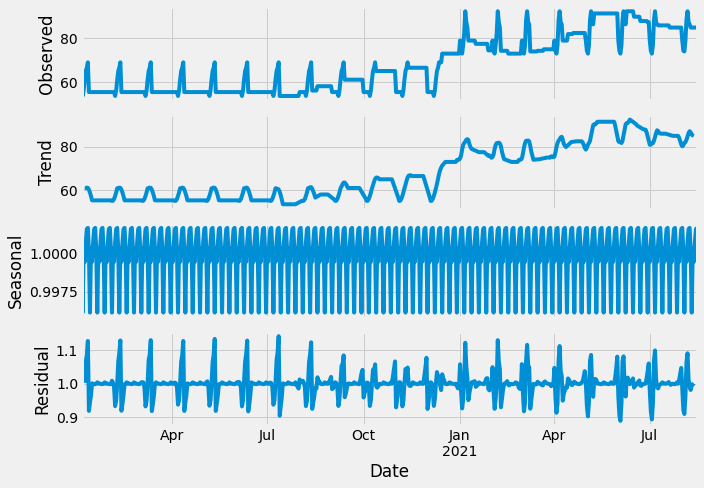

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_ts, model='multiplicative')
result.plot()
plt.show()

The plot above clearly shows that the sales of Galvalum is unstable, along with its obvious seasonality. We can also see increasing trend from December 2020.

### Stationarising the time series.

First, we need to check if a series is stationary or not.

**ADF (Augmented Dickey-Fuller) Test** is used to check if a series is stationary or not.

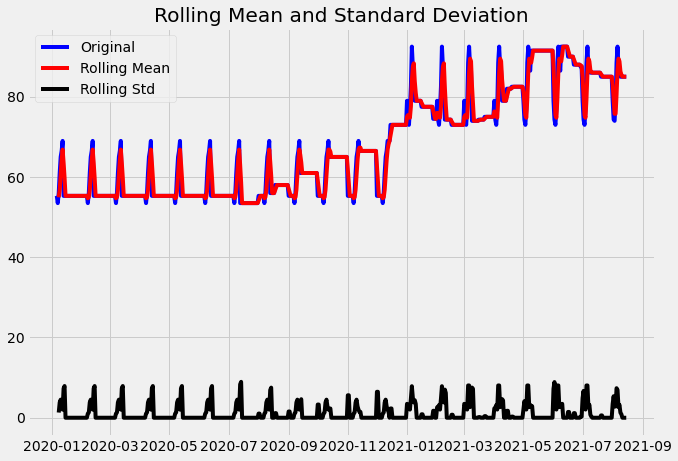

Results of dickey fuller test
Test Statistics                 -1.103927
p-value                          0.713503
No. of lags used                11.000000
Number of observations used    576.000000
critical value (1%)             -3.441754
critical value (5%)             -2.866571
critical value (10%)            -2.569449
dtype: float64


In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(3).mean()
    rolstd = timeseries.rolling(3).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    #perform dickey fuller test  
    print("Results of dickey fuller test")
    adft = adfuller(timeseries['Galvalum'],autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_ts)

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis (i.e., the series is not stationary). Also, the test statistics is greater than the critical values. so the data is non-stationary.    

To get a stationary series, we need to eliminate the trend and seasonality from the series.               

we start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series. A rolling average is calculated by taking input for the past 3 months and giving a mean galvalum value at every point further ahead in series.

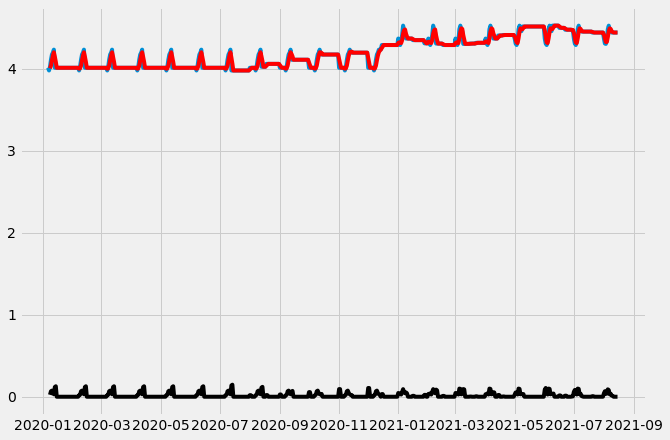

In [ ]:
df_log = np.log(df_ts)
moving_avg = df_log.rolling(3).mean()
std_dev = df_log.rolling(3).std()
plt.plot(df_log)
plt.plot(moving_avg, color="red")
plt.plot(std_dev, color ="black")
plt.show()

After finding the mean, we take the difference of the series and the mean at every point in the series.

This way, we eliminate trends out of a series and obtain a more stationary series.

In [ ]:
df_log_moving_avg_diff = df_log-moving_avg
df_log_moving_avg_diff.dropna(inplace=True)

Perform the Dickey-Fuller test (ADFT) once again. We have to perform this function every time to check whether the data is stationary or not.

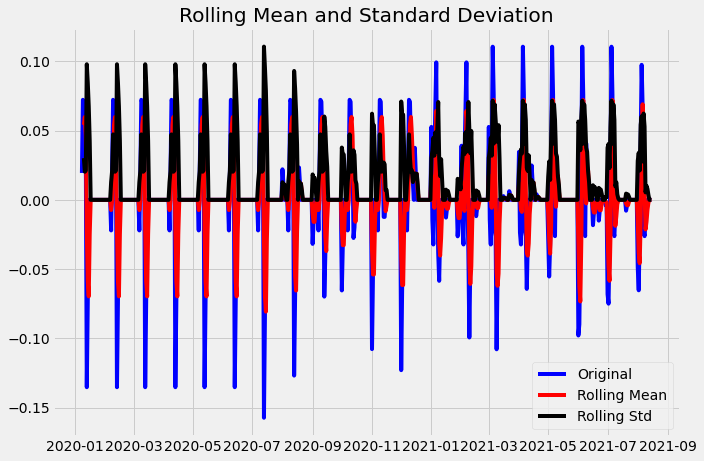

Results of dickey fuller test
Test Statistics               -1.027914e+01
p-value                        3.820353e-18
No. of lags used               1.000000e+01
Number of observations used    5.750000e+02
critical value (1%)           -3.441774e+00
critical value (5%)           -2.866580e+00
critical value (10%)          -2.569454e+00
dtype: float64


In [ ]:
test_stationarity(df_log_moving_avg_diff)

From the above graph, we observed that the data attained stationarity.

We need to check the weighted average, to understand the trend of the data in time series. Take the previous log data and perform the following operation.

In [ ]:
weighted_average = df_log.ewm(halflife=3, min_periods=0,adjust=True).mean()

The exponential moving average (EMA) is a weighted average of the last n prices, where the weighting decreases exponentially with each previous price/period. In other words, the formula gives recent prices more weight than past prices.

Previously we subtracted df_log with moving average, now take the same df_log and subtract with weighted_average and perform the Dickey-Fuller test (ADFT) once again.

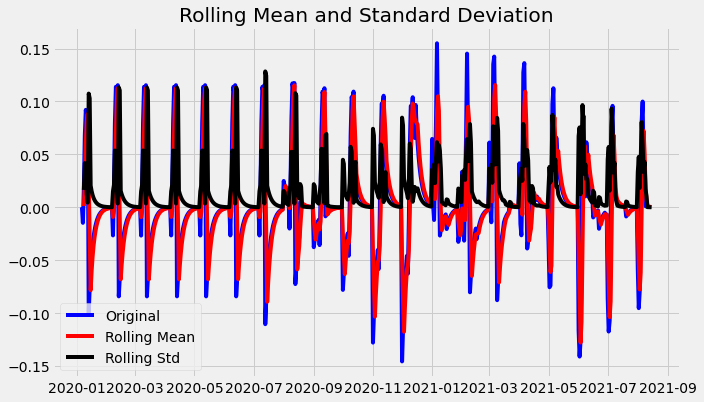

Results of dickey fuller test
Test Statistics               -8.796726e+00
p-value                        2.166375e-14
No. of lags used               1.000000e+01
Number of observations used    5.770000e+02
critical value (1%)           -3.441734e+00
critical value (5%)           -2.866562e+00
critical value (10%)          -2.569445e+00
dtype: float64


In [ ]:
logScale_weightedMean = df_log-weighted_average
from pylab import rcParams
rcParams['figure.figsize'] = 10,6
test_stationarity(logScale_weightedMean)

From the above graph, we observed that the data attained stationarity. We also see that the test statistics is relatively lower than critical value.


There can be cases when there is a high seasonality in the data.

In those cases, just removing the trend will not help much. We need to also take care of the **seasonality** in the series. One such method for this task is **differencing**.

**Differencing** is a method of **transforming a time series dataset**.

It can be used to remove the **series dependence on time**, so-called **temporal dependence**. This includes structures like **trends** and **seasonality**. Differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) trend and seasonality.

Differencing is performed by subtracting the previous observation from the current observation.
Perform the Dickey-Fuller test (ADFT) once again.



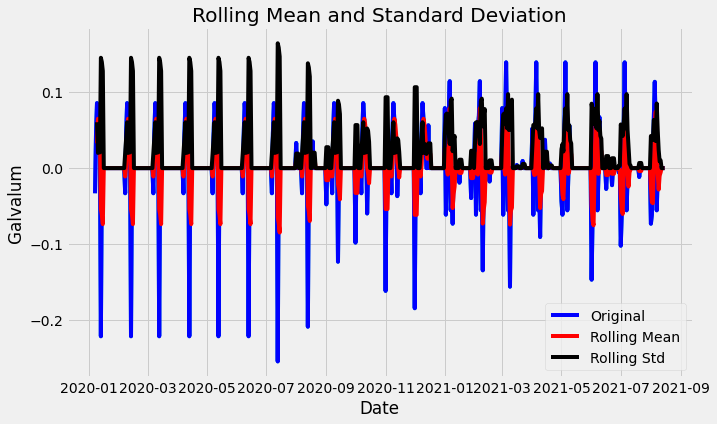

Results of dickey fuller test
Test Statistics               -1.010711e+01
p-value                        1.023032e-17
No. of lags used               1.100000e+01
Number of observations used    5.750000e+02
critical value (1%)           -3.441774e+00
critical value (5%)           -2.866580e+00
critical value (10%)          -2.569454e+00
dtype: float64


In [ ]:
df_log_diff = df_log - df_log.shift()
plt.title("Shifted timeseries")
plt.xlabel("Date")
plt.ylabel("Galvalum")
plt.plot(df_log_diff)#Let us test the stationarity of our resultant series
df_log_diff.dropna(inplace=True)
# Perform the Dickey-Fuller test (ADFT) 
test_stationarity(df_log_diff)

The next step is to perform decomposition which provides a structured way of thinking about a time series forecasting problem, both generally in terms of modeling complexity and specifically in terms of how to best capture each of these components in a given model. Finally, perform the Dickey-Fuller test (ADFT) once again.

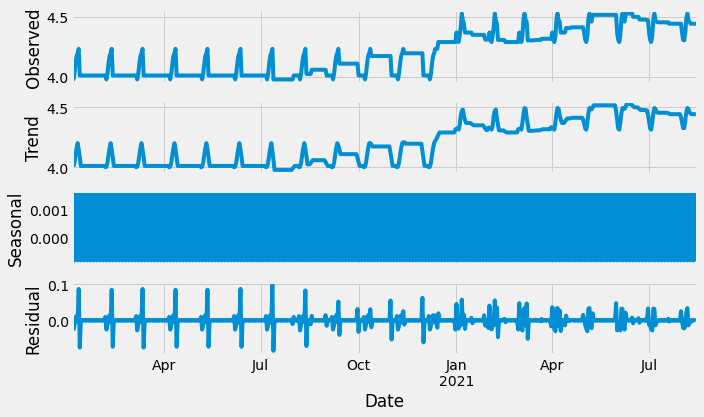

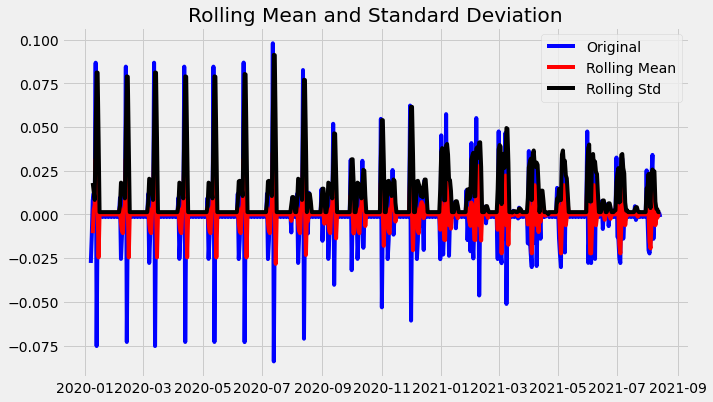

Results of dickey fuller test
Test Statistics               -1.050579e+01
p-value                        1.055164e-18
No. of lags used               1.900000e+01
Number of observations used    5.660000e+02
critical value (1%)           -3.441956e+00
critical value (5%)           -2.866660e+00
critical value (10%)          -2.569497e+00
dtype: float64


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_log, model='additive', freq = 3)
result.plot()
plt.show()
trend = result.trend.dropna()
seasonality = result.seasonal.dropna()
residual = result.resid.dropna()
# Perform Dickey-Fuller test (ADFT
test_stationarity(residual)

After the decomposition, if we look at the residual then we have clearly a flat line for both mean and standard deviation. We have got our stationary series and now we can move to find the best parameters for our model.

**Finding the best parameters for our model**

 First, we need to determine optimal parameters for our model. For those optimal parameters, we need ACF plot.

A nonseasonal ARIMA model is classified as an “ARIMA(p,d,q)” model, where:

p → Number of autoregressive terms,

d → Number of nonseasonal differences needed for stationarity, and

q → Number of lagged forecast errors in the prediction equation.

Values of p and q come through ACF plot.

**Autocorrelation Function(ACF)**

A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function, or the acronym ACF. This plot is sometimes called a correlogram or an autocorrelation plot. In this we can calculate the correlation for time series observations with previous time steps, called lags

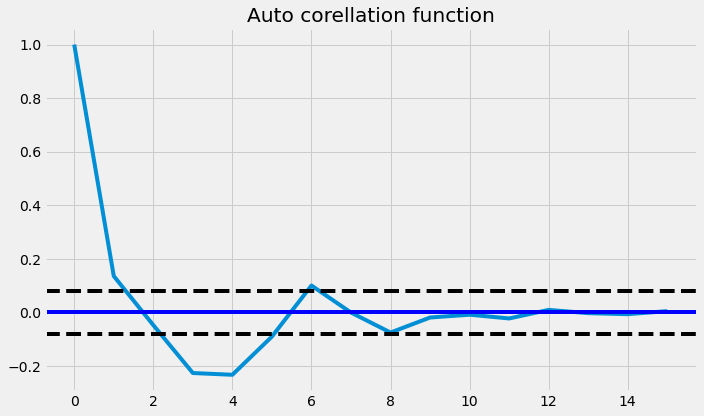

In [ ]:
from statsmodels.tsa.stattools import acf
# we use d value here(data_log_shift)
acf = acf(df_log_diff, nlags=15)
plt.plot(acf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.title('Auto corellation function')
plt.tight_layout()#plot ACF

In order to find the p and q values from the above graph, we need to check, where the graph cuts off the origin or drops to zero for the first time from the above graph the p and q values are merely close to 2 where the graph cuts off the origin ( draw the line to x-axis) now we have p,d,q values. So now we can substitute in the ARIMA model and let's see the output.

In [ ]:
mod = sm.tsa.statespace.SARIMAX(df_log,
                                order=(2, 1, 2),         # order = (p,d,q)
                                seasonal_order=(2, 1, 2, 3),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1787      0.088      2.021      0.043       0.005       0.352
ar.L2         -0.7265      0.079     -9.143      0.000      -0.882      -0.571
ma.L1         -0.0821      0.072     -1.134      0.257      -0.224       0.060
ma.L2          0.8359      0.069     12.072      0.000       0.700       0.972
ar.S.L3       -0.5390      0.279     -1.933      0.053      -1.086       0.008
ar.S.L6       -0.0228      0.087     -0.262      0.793      -0.194       0.148
ma.S.L3       -0.5733      1.003     -0.571      0.568      -2.540       1.393
ma.S.L6       -0.4265      0.471     -0.906      0.365      -1.349       0.496
sigma2         0.0016      0.002      1.069      0.285      -0.001       0.005


The summary attribute that results from the output of SARIMAX returns a significant amount of information, but we’ll focus our attention on the table of coefficients. The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight.

### Validating Forecasts

We have obtained a model for our time series that can now be used to produce forecasts. We start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts. The get_prediction() and conf_int() attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2021-05-15'), dynamic=False)
pred_ci = pred.conf_int()

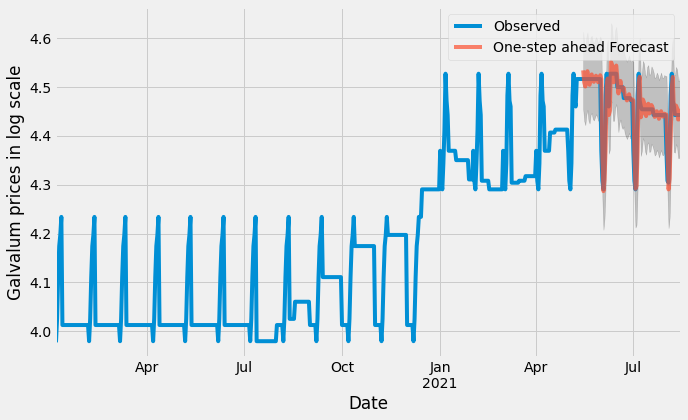

In [ ]:
ax = df_log['2020':].plot(legend=False)
pred.predicted_mean.plot(ax=ax, legend=False, alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Galvalum prices in log scale')
ax.figure.legend(['Observed', 'One-step ahead Forecast'], bbox_to_anchor=(1.,1),loc=1, bbox_transform=ax.transAxes)

plt.show()

The line plot is showing the observed values compared to the forecast predictions. Overall, our forecasts align with the true values very well.

It is also useful to quantify the accuracy of our forecasts. We will use the MSE (Mean Squared Error), which summarizes the average error of our forecasts.

In [ ]:
y_forecasted = pred.predicted_mean.values
y_truth = df_log['2021-05-15':].values.flatten()

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.0


### Producing and Visualizing Forecasts

Now we use our seasonal ARIMA time series model to forecast future values. The get_forecast() attribute of our time series object can compute forecasted values for a specified number of steps ahead.

In [ ]:
# Get forecast 92 steps ahead in future
pred_uc = results.get_forecast(steps=92)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

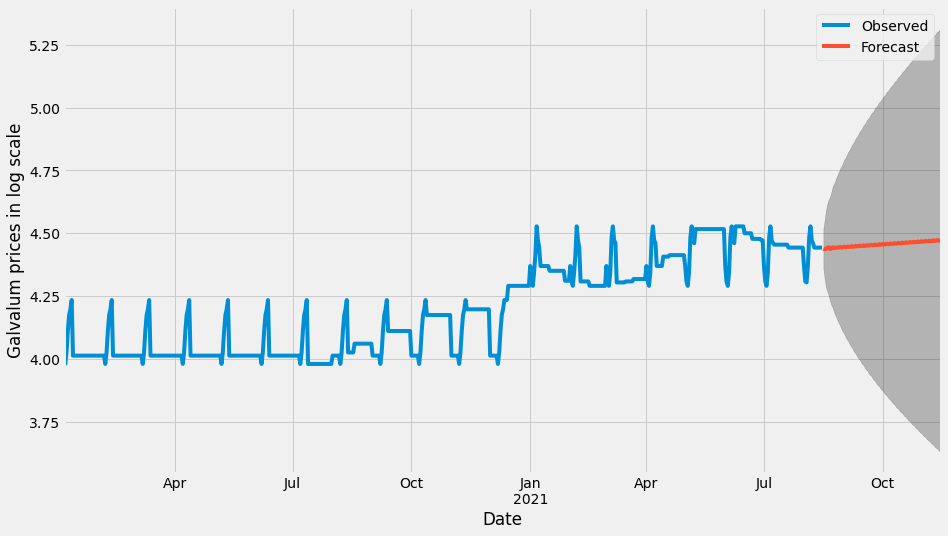

In [ ]:
ax = df_log.plot(figsize=(14, 8), legend=False)
pred_uc.predicted_mean.plot(ax=ax, legend=False)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Galvalum prices in log scale')
ax.figure.legend(['Observed', 'Forecast'], bbox_to_anchor=(1.,1),loc=1, bbox_transform=ax.transAxes)

plt.show()

Both the forecasts and associated confidence interval that we have generated can now be used to further understand the time series and foresee what to expect. Our forecasts show that the time series is expected to continue increasing at a steady pace.

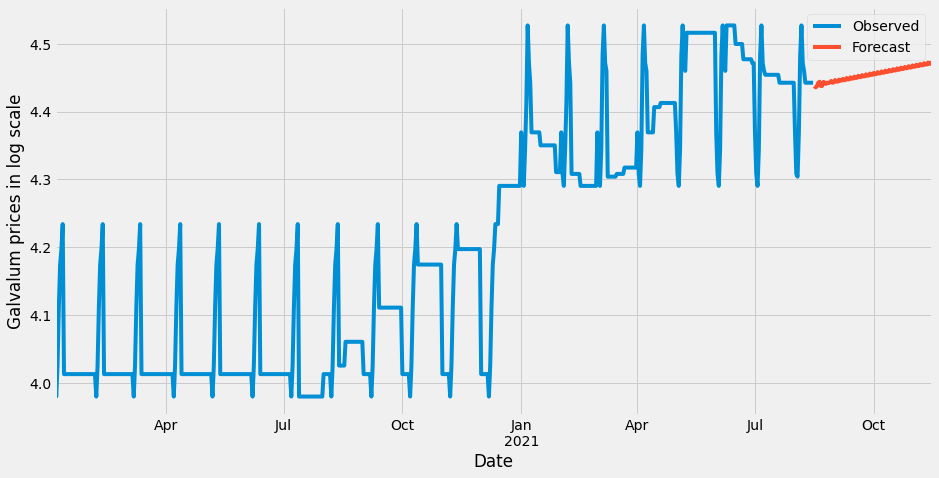

In [ ]:
### Graphs without the confident interval 
pred_uc = results.get_forecast(steps=92)
ax = df_log.plot(legend=False, figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, legend=False)
ax.set_xlabel('Date')
ax.set_ylabel('Galvalum prices in log scale')
ax.figure.legend(['Observed', 'Forecast'], bbox_to_anchor=(1.,1),loc=1, bbox_transform=ax.transAxes)
plt.show()

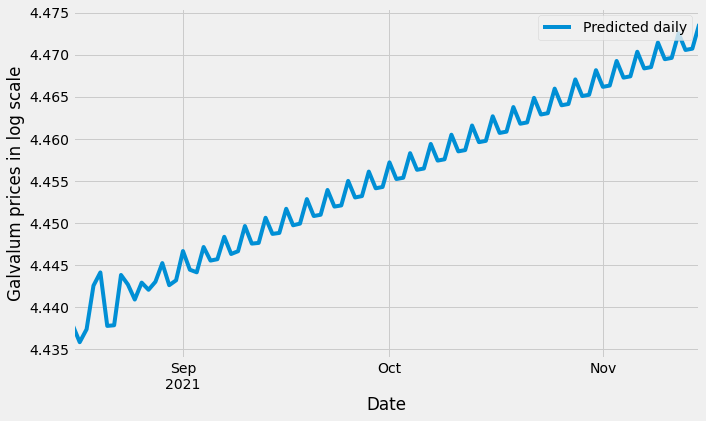

In [ ]:
### Graphs show only the perdiected period
pred_uc = results.get_forecast(steps=92)
pred_uc.predicted_mean.plot(legend=False)
plt.xlabel('Date')
plt.ylabel('Galvalum prices in log scale')
plt.legend(['Predicted daily'], bbox_to_anchor=(1.,1),loc=1)
plt.show()

# Save the predictions in csv

In [ ]:
predictions = pred_uc.predicted_mean.reset_index(drop=False).rename(columns = {'index':'Date', 0:'Predicted_Galvalum_prices'})

In [ ]:
predictions

,Date,Predicted_Galvalum_prices
0,2021-08-16,4.437848
1,2021-08-17,4.435859
2,2021-08-18,4.437393
3,2021-08-19,4.442571
4,2021-08-20,4.444145
...,...,...
87,2021-11-11,4.469620
88,2021-11-12,4.472541
89,2021-11-13,4.470561
90,2021-11-14,4.470715


In [ ]:
# Convert predictions in log scale to original scale i.e., original data
predictions['Predicted_Galvalum_prices'] = np.exp(predictions['Predicted_Galvalum_prices'])

In [ ]:
predictions

,Date,Predicted_Galvalum_prices
0,2021-08-16,84.592691
1,2021-08-17,84.424624
2,2021-08-18,84.554254
3,2021-08-19,84.993202
4,2021-08-20,85.127021
...,...,...
87,2021-11-11,87.323533
88,2021-11-12,87.578937
89,2021-11-13,87.405740
90,2021-11-14,87.419184


In [ ]:
# Save predictions in csv
predictions.to_csv('3Month_predictions_Galvalum_prices.csv', index=False)